In [8]:
!pip install openmeteo-requests requests requests_cache retry_requests lxml pandas

🚀 Mengambil data ERA5 via Open-Meteo...
✅ Selesai! Data siap.
                           temperature    humidity  rain_mm     pressure
date                                                                    
2025-10-01 00:00:00+07:00    23.127001  100.000000      0.8  1007.460449
2025-10-01 01:00:00+07:00    23.227001  100.000000      0.7  1007.063293
2025-10-01 02:00:00+07:00    23.077002  100.000000      0.3  1006.264404
2025-10-01 03:00:00+07:00    22.777000  100.000000      0.0  1006.061340
2025-10-01 04:00:00+07:00    22.477001   99.696617      0.0  1006.456116


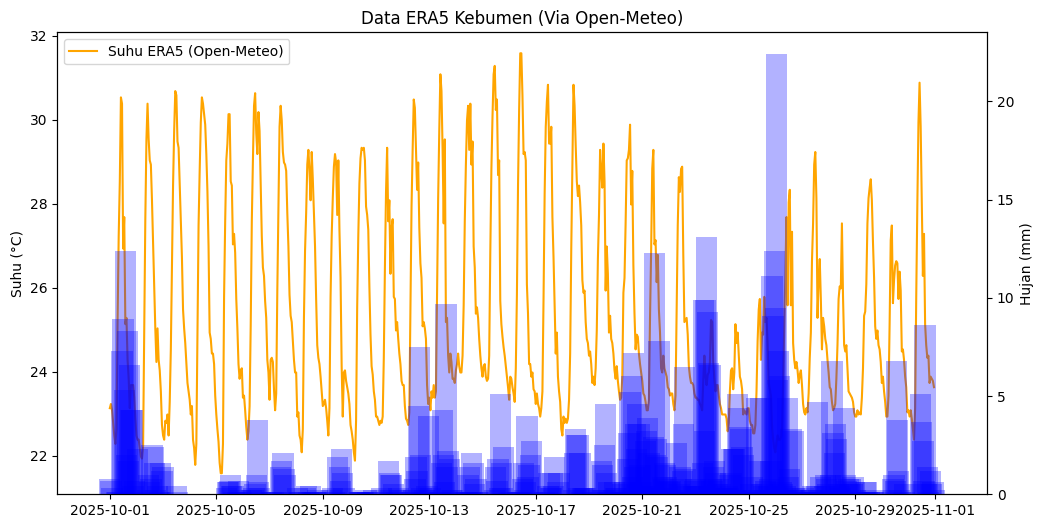

In [9]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt

# 1. Setup Client (Cache biar hemat kuota)
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# 2. Request Data (KEBUMEN)
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": -7.66,   # Koordinat Kebumen
	"longitude": 109.65,
	"start_date": "2025-10-01",
	"end_date": "2025-10-31", # Coba ambil 1 bulan
	"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "surface_pressure"],
	"timezone": "Asia/Jakarta" # Langsung WIB! Gak perlu convert manual
}

print("🚀 Mengambil data ERA5 via Open-Meteo...")
responses = openmeteo.weather_api(url, params=params)

# 3. Parsing Hasil
response = responses[0]
hourly = response.Hourly()

# Ambil data per variabel
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_humidity = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_pressure = hourly.Variables(3).ValuesAsNumpy()

# Buat DataFrame
date_range = pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)

df = pd.DataFrame(data = {
	"date": date_range,
	"temperature": hourly_temperature_2m,
	"humidity": hourly_humidity,
	"rain_mm": hourly_rain,
	"pressure": hourly_pressure
})

# Konversi Timezone (Dari UTC API ke WIB sudah ditangani parameter, tapi index perlu disesuaikan)
df = df.set_index('date')
df.index = df.index.tz_convert('Asia/Jakarta')

print("✅ Selesai! Data siap.")
print(df.head())

# 4. Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df.index, df['temperature'], color='orange', label='Suhu ERA5 (Open-Meteo)')
ax1.set_ylabel('Suhu (°C)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.bar(df.index, df['rain_mm'], color='blue', alpha=0.3, label='Hujan ERA5')
ax2.set_ylabel('Hujan (mm)')

plt.title('Data ERA5 Kebumen (Via Open-Meteo)')
plt.show()